## MINI-RFs on Hierarchical Clusters

    This is a feature selection algorithm based on hierarchically clustered partitions. The idea here is to reduce the overall number of combinations by creating partitions for combinations. This is mathematically sound because the number of combinations formed from 30 variables is much larger than the number of combinations formed from 10 variables multiplied by 3. This thought can be expressed as an inequality: 2(30 choose 15 + 30 choose 14 + 30 choose 13 ...) >> 6(10 choose 5 + 10 choose 4 + 10 choose 3 ...). The goal is to create partitions of variables such that variables within each partition are "related" to eachother BUT NOT to variables in other partitions. RFs will be used to find a subset of variables within each partition that can predict the remaining variables in the partition. 

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import torch.nn as nn
import torch
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [2]:
df = pd.read_excel(r"C:\Users\joshu\Downloads\labs_complete.xlsx", index_col = "subject_id")
df.columns = df.columns.str.replace("_percentile", "")
df

,51221,51265,50912,50971,51222,51301,51249,51279,51250,51248,...,50813,50863,50885,50820,50862,50802,50821,50804,50818,50910
subject_id,,,,,,,,,,,,,,,,,,,,,
12138413,0.653935,0.471492,0.668170,0.122564,0.585660,0.379092,0.273604,0.508236,0.829349,0.653375,...,0.328330,0.188457,0.750168,0.371901,0.539988,0.660286,0.141536,0.662118,0.722870,0.642922
12988457,0.744261,0.549488,0.764983,0.873920,0.600321,0.128942,0.115307,0.782644,0.367417,0.135998,...,0.557945,0.414605,0.663706,0.807163,0.603970,0.469087,0.234647,0.287035,0.146159,0.226079
18624683,0.074887,0.071672,0.197234,0.012156,0.120607,0.564170,0.834371,0.080755,0.603556,0.757634,...,0.875884,0.103988,0.750168,0.485908,0.374253,0.273487,0.058992,0.287035,0.304645,0.898581
11914968,0.870576,0.616041,0.668170,0.122564,0.921972,0.945371,0.875151,0.799719,0.661008,0.850342,...,0.974600,0.565034,0.396615,0.154482,0.770091,0.108031,0.535329,0.117103,0.471935,0.878056
17957742,0.433584,0.264405,0.563640,0.886779,0.430006,0.735389,0.424468,0.512455,0.306750,0.246183,...,0.119353,0.475349,0.780999,0.872643,0.425130,0.660286,0.916355,0.436496,0.173674,0.886206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10581271,0.851529,0.936860,0.197234,0.911493,0.799458,0.880900,0.358276,0.885898,0.306750,0.246183,...,0.735748,0.723036,0.841488,0.807163,0.660628,0.660286,0.538191,0.436496,0.234206,0.343193
13724012,0.100652,0.692532,0.834837,0.921640,0.083049,0.620707,0.148654,0.129871,0.423765,0.188027,...,0.977775,0.987380,0.959450,0.442467,0.323569,0.187239,0.042263,0.186881,0.200969,0.492001
17427308,0.588070,0.970488,0.895270,0.900040,0.460534,0.883511,0.104058,0.383889,0.921153,0.653375,...,0.875884,0.788995,0.841488,0.335876,0.374253,0.273487,0.009905,0.436496,0.615012,0.780260


In [3]:
labs = {
    "51221": "Hematocrit",
    "51265": "Platelet Count",
    "50912": "Creatinine",
    "50971": "Potassium",
    "51222": "Hemoglobin",
    "51301": "White Blood Cells",
    "51249": "MCHC",
    "51279": "Red Blood Cells",
    "51250": "MCV",
    "51248": "MCH",
    "51277": "RDW",
    "51006": "Urea Nitrogen",
    "50983": "Sodium",
    "50902": "Chloride",
    "50882": "Bicarbonate",
    "50868": "Anion Gap",
    "50931": "Glucose",
    "50960": "Magnesium",
    "50893": "Calcium, Total",
    "50970": "Phosphate",
    "51237": "INR(PT)",
    "51274": "PT",
    "51275": "PTT",
    "51146": "Basophils",
    "51256": "Neutrophils",
    "51254": "Monocytes",
    "51200": "Eosinophils",
    "51244": "Lymphocytes",
    "52172": "RDW-SD",
    "50934": "H",
    "51678": "L",
    "50947": "I",
    "50861": "Alanine Aminotransferase (ALT)",
    "50878": "Asparate Aminotransferase (AST)",
    "50813": "Lactate",
    "50863": "Alkaline Phosphatase",
    "50885": "Bilirubin, Total",
    "50820": "pH",
    "50862": "Albumin",
    "50802": "Base Excess",
    "50821": "pO2",
    "50804": "Calculated Total CO2",
    "50818": "pCO2",
    "52075": "Absolute Neutrophil Count",
    "52073": "Absolute Eosinophil Count",
    "52074": "Absolute Monocyte Count",
    "52069": "Absolute Basophil Count",
    "51133": "Absolute Lymphocyte Count",
    "50910": "Creatine Kinase (CK)",
    "52135": "Immature Granulocytes"
}
labs_reversed = {value: key for key, value in labs.items()}

In [4]:
encode = lambda x: [labs_reversed[i] for i in x]
decode = lambda x: [labs[i] for i in x]

### Cluster Data

In [10]:
df_decoded = df
df_decoded.columns = decode(df.columns)

In [18]:
Z = linkage(df_decoded.corr(), method="ward")

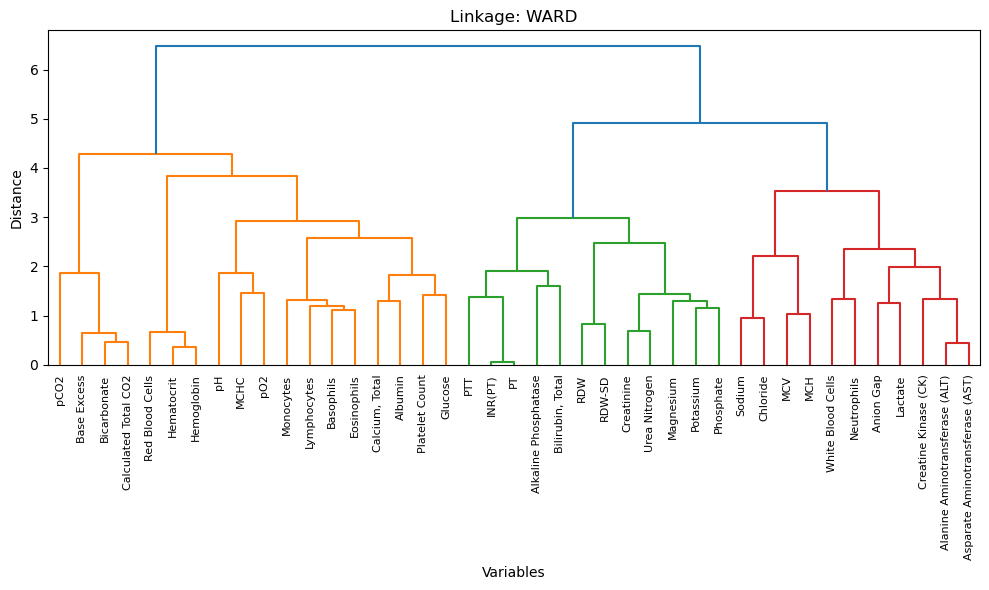

In [19]:
plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendrogram of Variables')
plt.xlabel('Variables')
plt.ylabel('Distance')

dendrogram(Z, labels=df_decoded.columns, orientation='top', leaf_rotation=90)
plt.title(f'Linkage: WARD')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()

### Define partitions

In [5]:
outputs_only = ["MCHC", "MCV", "MCH", "RDW", "RDW-SD", "Base Excess", "Calculated Total CO2","Anion Gap","INR(PT)"]
group_1 = ["pCO2", "Bicarbonate", "Red Blood Cells", "Hematocrit", 
           "Hemoglobin", "pH", "pO2", "Monocytes", "Lymphocytes", 
          "Basophils", "Eosinophils", "Calcium, Total", "Platelet Count", "Glucose"]
group_2 = ["PTT", "PT", "Bilirubin, Total", "Alkaline Phosphatase", "Creatinine", "Urea Nitrogen",
          "Magnesium", "Potassium", "Phosphate"]
group_3 = ["Chloride", "White Blood Cells", "Neutrophils", "Lactate",
          "Alanine Aminotransferase (ALT)", "Asparate Aminotransferase (AST)",
          "Creatine Kinase (CK)"]

In [6]:
out_encoded = encode(outputs_only)
group_1_encoded = encode(group_1)
group_2_encoded = encode(group_2)
group_3_encoded = encode(group_3)

### Get combinations for model

In [7]:
def get_combinations(var_list):

    comb_list = []

    for i in range(1,len(var_list)):

        combs = list(combinations(var_list, i))

        comb_list = comb_list + combs
        
    return comb_list

In [8]:
group_1_combs = get_combinations(group_1_encoded)
print(len(group_1_combs))
group_2_combs = get_combinations(group_2_encoded)
print(len(group_2_combs))
group_3_combs = get_combinations(group_3_encoded)
print(len(group_3_combs))

16382
510
126


### Test combinations with random forest

In [9]:
def rf(xs, y, n_estimators=200, max_samples=50,
       max_features=0.75, min_samples_leaf=10, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
MSE = nn.MSELoss()

In [10]:
df.columns

Index(['51221', '51265', '50912', '50971', '51222', '51301', '51249', '51279',
       '51250', '51248', '51277', '51006', '50983', '50902', '50882', '50868',
       '50931', '50960', '50893', '50970', '51237', '51274', '51275', '51146',
       '51256', '51254', '51200', '51244', '52172', '50861', '50878', '50813',
       '50863', '50885', '50820', '50862', '50802', '50821', '50804', '50818',
       '50910'],
      dtype='object')

In [11]:
def test_combinations(combs, cols, df):
    
    loss_df= pd.DataFrame(columns=['inputs', 'outputs', 'loss'])

    count = 0

    for comb in combs:

        comb = list(comb)
        
        targets = list(set(cols) - set(combs))

        y_df = df[targets]

        x_df = df[comb]

        y = y_df.to_numpy()
        x = x_df.to_numpy()

        r,c = y.shape 
        if c == 1:
            y = y.ravel() # prevents mismatched shapes in the second dimension

        m = rf(x,y)

        y_preds = m.predict(x)

        loss = float(MSE(torch.tensor(y), torch.tensor(y_preds)))

        loss_df.loc[len(loss_df)] = [decode(comb), decode(targets), loss]

        count += 1
        
        if count%50 == 0:
            
            print(loss)
            
    return loss_df

In [12]:
group1_losses = test_combinations(group_1_combs, group_1_encoded, df)
group1_losses

0.06774949785167461
0.07470653960593143
0.06986606806057458
0.06207798922648995
0.06774253183909258
0.06397433798075634
0.06355735462419836
0.07173958673834283
0.07451420652454285
0.06975372962069736
0.0615328205121142
0.06063291178048085
0.061965511914296764
0.07010820078880964
0.0669140447469382
0.06203888233113709
0.060187484855440634
0.06794520032871205
0.06887184970741865
0.06274320822615415
0.06344590156482191
0.06215390003515898
0.06411335652057087
0.06095187823165125
0.06228463106488458
0.06277164755340207
0.06979253881916274
0.06868321640146
0.06889239344946894
0.06105823101605581
0.05975217416463125
0.059955998728680404
0.0674858576639673
0.06115895885989751
0.061798877761747716
0.06108755784844496
0.060442230632991215
0.059496230950760565
0.059217498390129734
0.059892388714002445
0.05969133436084656
0.06683806070446718
0.06789591769238183
0.06023712618799755
0.06161777857005393
0.06166882242556594
0.06132110728772262
0.05979201445370311
0.06079364824912258
0.0612960319066968

,inputs,outputs,loss
0,[pCO2],"[pH, Platelet Count, Monocytes, Red Blood Cell...",0.078397
1,[Bicarbonate],"[pH, Platelet Count, Monocytes, Red Blood Cell...",0.079221
2,[Red Blood Cells],"[pH, Platelet Count, Monocytes, Red Blood Cell...",0.069920
3,[Hematocrit],"[pH, Platelet Count, Monocytes, Red Blood Cell...",0.068546
4,[Hemoglobin],"[pH, Platelet Count, Monocytes, Red Blood Cell...",0.069528
...,...,...,...
16377,"[pCO2, Bicarbonate, Red Blood Cells, Hematocri...","[pH, Platelet Count, Monocytes, Red Blood Cell...",0.058301
16378,"[pCO2, Bicarbonate, Red Blood Cells, Hemoglobi...","[pH, Platelet Count, Monocytes, Red Blood Cell...",0.058085
16379,"[pCO2, Bicarbonate, Hematocrit, Hemoglobin, pH...","[pH, Platelet Count, Monocytes, Red Blood Cell...",0.058613
16380,"[pCO2, Red Blood Cells, Hematocrit, Hemoglobin...","[pH, Platelet Count, Monocytes, Red Blood Cell...",0.058559


In [13]:
group2_losses = test_combinations(group_2_combs, group_2_encoded, df)
group2_losses

0.05973915800704077
0.06145229782582401
0.054645320597065415
0.056153999286418406
0.05621428357769882
0.054478803948028585
0.053779664793216046
0.05189211097004332
0.053788193411084075
0.0527986384241029


,inputs,outputs,loss
0,[PTT],"[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.072354
1,[PT],"[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.072534
2,"[Bilirubin, Total]","[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.077625
3,[Alkaline Phosphatase],"[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.076077
4,[Creatinine],"[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.069123
...,...,...,...
505,"[PTT, PT, Bilirubin, Total, Alkaline Phosphata...","[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.050881
506,"[PTT, PT, Bilirubin, Total, Creatinine, Urea N...","[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.051656
507,"[PTT, PT, Alkaline Phosphatase, Creatinine, Ur...","[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.051115
508,"[PTT, Bilirubin, Total, Alkaline Phosphatase, ...","[Urea Nitrogen, Alkaline Phosphatase, Phosphat...",0.051417


In [14]:
group3_losses = test_combinations(group_3_combs, group_3_encoded, df)
group3_losses

0.05449222999298626
0.0467963663747243


,inputs,outputs,loss
0,[Chloride],"[Alanine Aminotransferase (ALT), Creatine Kina...",0.069630
1,[White Blood Cells],"[Alanine Aminotransferase (ALT), Creatine Kina...",0.070226
2,[Neutrophils],"[Alanine Aminotransferase (ALT), Creatine Kina...",0.072057
3,[Lactate],"[Alanine Aminotransferase (ALT), Creatine Kina...",0.071057
4,[Alanine Aminotransferase (ALT)],"[Alanine Aminotransferase (ALT), Creatine Kina...",0.061280
...,...,...,...
121,"[Chloride, White Blood Cells, Neutrophils, Lac...","[Alanine Aminotransferase (ALT), Creatine Kina...",0.046333
122,"[Chloride, White Blood Cells, Neutrophils, Ala...","[Alanine Aminotransferase (ALT), Creatine Kina...",0.045776
123,"[Chloride, White Blood Cells, Lactate, Alanine...","[Alanine Aminotransferase (ALT), Creatine Kina...",0.046278
124,"[Chloride, Neutrophils, Lactate, Alanine Amino...","[Alanine Aminotransferase (ALT), Creatine Kina...",0.046729


### Plot Losses to find Good Ratio

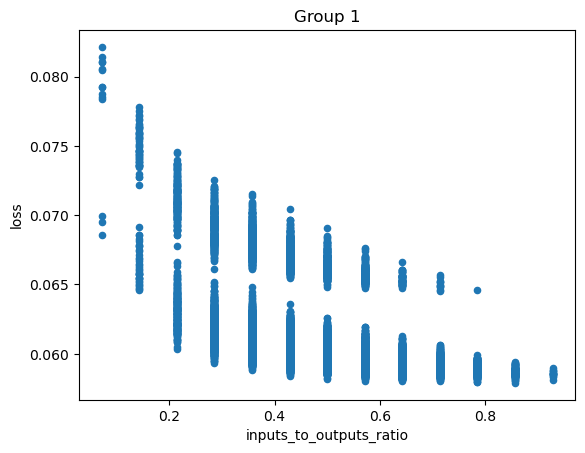

In [15]:
group1_losses["inputs_to_outputs_ratio"] = group1_losses["inputs"].apply(len)/group1_losses["outputs"].apply(len)
group1_losses["inputs_to_outputs_ratio"]
group1_losses.plot.scatter(x='inputs_to_outputs_ratio', y='loss', title='Group 1')
plt.show()

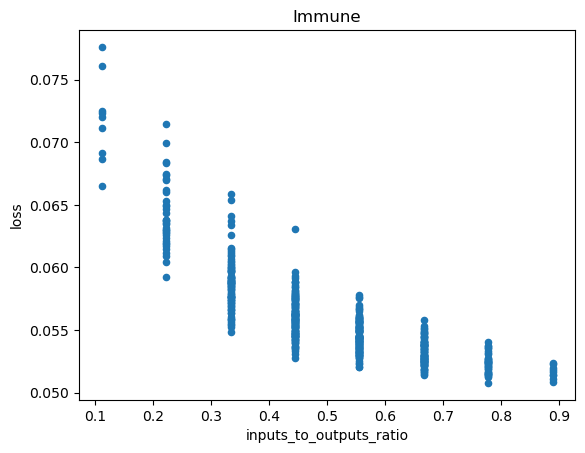

In [16]:
group2_losses["inputs_to_outputs_ratio"] = group2_losses["inputs"].apply(len)/group2_losses["outputs"].apply(len)
group2_losses["inputs_to_outputs_ratio"]
group2_losses.plot.scatter(x='inputs_to_outputs_ratio', y='loss', title='Immune')
plt.show()

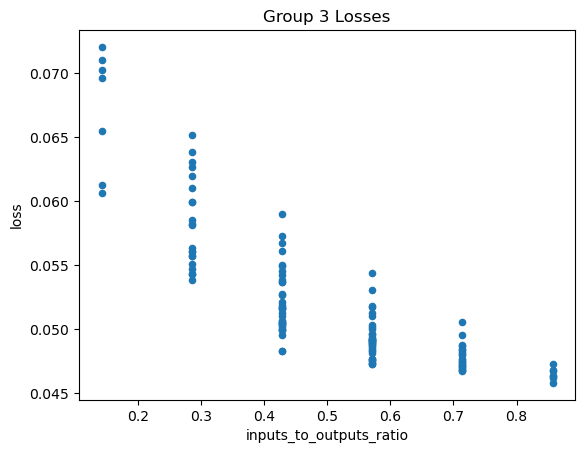

In [17]:
group3_losses["inputs_to_outputs_ratio"] = group3_losses["inputs"].apply(len)/group3_losses["outputs"].apply(len)
group3_losses["inputs_to_outputs_ratio"]
group3_losses.plot.scatter(x='inputs_to_outputs_ratio', y='loss', title='Group 3 Losses')
plt.show()

In [19]:
group1_losses.to_excel(r"C:\Users\joshu\Downloads\group1_losses.xlsx")
group2_losses.to_excel(r"C:\Users\joshu\Downloads\group2_losses.xlsx")
group3_losses.to_excel(r"C:\Users\joshu\Downloads\group3_losses.xlsx")

### Select variables based on results

In [34]:
group1_feats = group1_losses[group1_losses["inputs_to_outputs_ratio"] < 0.5].sort_values(by = "loss").iloc[0,0]
group2_feats = group2_losses[group2_losses["inputs_to_outputs_ratio"] < 0.5].sort_values(by = "loss").iloc[0,0]
group3_feats = group3_losses[group3_losses["inputs_to_outputs_ratio"] < 0.5].sort_values(by = "loss").iloc[0,0]

In [35]:
total_feats = list(set(group1_feats+group2_feats+group3_feats))

In [36]:
total_feats

['Hematocrit',
 'PTT',
 'Asparate Aminotransferase (AST)',
 'Chloride',
 'White Blood Cells',
 'Potassium',
 'Calcium, Total',
 'Phosphate',
 'Monocytes',
 'Eosinophils',
 'Urea Nitrogen',
 'pH',
 'pCO2']

### Test predictive power of features

In [37]:
cols = decode(df.columns.to_list())
targets = list(set(cols) - set(total_feats))
targets

['Albumin',
 'Alkaline Phosphatase',
 'Neutrophils',
 'pO2',
 'Magnesium',
 'MCH',
 'Red Blood Cells',
 'Creatinine',
 'Platelet Count',
 'PT',
 'Alanine Aminotransferase (ALT)',
 'Base Excess',
 'MCV',
 'Hemoglobin',
 'RDW-SD',
 'Creatine Kinase (CK)',
 'Glucose',
 'Bicarbonate',
 'Bilirubin, Total',
 'INR(PT)',
 'Lymphocytes',
 'MCHC',
 'Sodium',
 'Anion Gap',
 'RDW',
 'Lactate',
 'Calculated Total CO2',
 'Basophils']

In [38]:
loss_df= pd.DataFrame(columns=['output', 'loss'])

for target in targets:

    y_df = df[encode([target])]

    x_df = df[encode(total_feats)]

    y = y_df.to_numpy()
    x = x_df.to_numpy()

    r,c = y.shape 
    if c == 1:
        y = y.ravel() # prevents mismatched shapes in the second dimension

    m = rf(x,y)

    y_preds = m.predict(x)

    loss = float(MSE(torch.tensor(y), torch.tensor(y_preds)))

    loss_df.loc[len(loss_df)] = [target, loss]

    print(loss)

0.05240846299892011
0.06862866919874067
0.045230976445003956
0.06202678088299407
0.07576331738588067
0.07797258088962807
0.02313726282381757
0.0326059682360122
0.06700642292227206
0.051930255040054836
0.0345605191713781
0.04571224777515266
0.07889656160190381
0.012919020712829094
0.0654965926106678
0.060712122049020094
0.08807147738215518
0.05678284847706393
0.05610674307245417
0.04147755894060861
0.053051504720338996
0.06248536330336061
0.05272002597021402
0.04855572924289597
0.06606240802184893
0.06201465631938231
0.04186838499032853
0.043854793923258646


In [39]:
loss_df

,output,loss
0,Albumin,0.052408
1,Alkaline Phosphatase,0.068629
2,Neutrophils,0.045231
3,pO2,0.062027
4,Magnesium,0.075763
5,MCH,0.077973
6,Red Blood Cells,0.023137
7,Creatinine,0.032606
8,Platelet Count,0.067006
9,PT,0.051930


### Run a tuning experiment on the selected features

In [ ]:
df_test = pd.read_csv(r"C:\Users\joshu\Downloads\test (1).csv")
df_percentiles = df_test.loc[:,df_test.columns.str.contains('percentile')]
df_percentiles.index = df_test["subject_id"]
least_common = ['50947','50934','51678','52135','51133','52069','52074','52073','52075']
drop = [x + "_percentile" for x in least_common]
df_common = df_percentiles.drop(drop, axis=1)
df_test = df_common.dropna()
df_test.columns = df.columns.str.replace("_percentile", "")

In [ ]:
import optuna
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

Y = df[encode(targets)]
X = df[encode(total_feats)]

x_test = df_test[encode(total_feats)]
y_test = df_test[encode(targets)]


def objective(trial):
    # Define hyperparameters to tune
    params = {
        #n_estimators=200, max_samples=50,
        #max_features=0.75, min_samples_leaf=10
        'n_estimators': trial.suggest_int('n_estimators', 10, 700),
        'min_samples_leaf': 1,
        'max_features': trial.suggest_float('max_features', 0.5,1.0),
        'max_samples': trial.suggest_int('max_samples', 50, 360),
        'max_depth': trial.suggest_int('max_depth', 10, 200, log=True),
    }

    # Create model
    model = RandomForestRegressor(**params)

    # Train model
    model.fit(X, Y)

    # Evaluate model
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials= 1000)

# Print the best hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  MSE: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study)

# Plot parameter importance
optuna.visualization.plot_param_importances(study)

# Plot slice plot
optuna.visualization.plot_slice(study)

### Use optimized params

In [47]:
def rf2(xs, y, n_estimators=44, max_samples=329,
       max_features=0.9128376331116463, min_samples_leaf=1, max_depth= 23, **kwargs):
    return RandomForestRegressor(n_jobs=-1, max_depth=max_depth, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
MSE = nn.MSELoss()

In [48]:
loss_df= pd.DataFrame(columns=['output', 'loss'])

for target in targets:

    y_df = df[encode([target])]

    x_df = df[encode(total_feats)]

    y = y_df.to_numpy()
    x = x_df.to_numpy()

    r,c = y.shape 
    if c == 1:
        y = y.ravel() # prevents mismatched shapes in the second dimension

    m = rf2(x,y)

    y_preds = m.predict(x)

    loss = float(MSE(torch.tensor(y), torch.tensor(y_preds)))

    loss_df.loc[len(loss_df)] = [target, loss]

    print(loss)

ValueError: `max_samples` must be <= n_samples=363 but got value 6230

In [42]:
loss_df

,output,loss
0,Albumin,0.009566
1,Alkaline Phosphatase,0.013010
2,Neutrophils,0.007101
3,pO2,0.011383
4,Magnesium,0.012640
5,MCH,0.013886
6,Red Blood Cells,0.002979
7,Creatinine,0.006114
8,Platelet Count,0.012558
9,PT,0.008812


### Use test split to see if model is overfitting

In [43]:
df_test = pd.read_csv(r"C:\Users\joshu\Downloads\test (1).csv")
df_percentiles = df_test.loc[:,df_test.columns.str.contains('percentile')]
df_percentiles.index = df_test["subject_id"]
least_common = ['50947','50934','51678','52135','51133','52069','52074','52073','52075']
drop = [x + "_percentile" for x in least_common]
df_common = df_percentiles.drop(drop, axis=1)
df_test = df_common.dropna()
df_test.columns = df.columns.str.replace("_percentile", "")

In [44]:
df_test.to_excel(r"C:\Users\joshu\Downloads\test_complete.xlsx")

In [45]:
loss_df= pd.DataFrame(columns=['output', 'loss'])

for target in targets:
    
    x_df = df[encode(total_feats)]
    y_df = df[encode([target])]
    
    x_test_df = df_test[encode(total_feats)]
    y_test_df = df_test[encode([target])]

    y = y_df.to_numpy()
    x = x_df.to_numpy()
    
    x_test = x_test_df.to_numpy()
    y_test = y_test_df.to_numpy()
    
    y = y.ravel()
    y_test = y_test.ravel() # prevents mismatched shapes in the second dimension

    m = rf2(x,y)

    y_preds = m.predict(x_test)

    loss = float(MSE(torch.tensor(y_test), torch.tensor(y_preds)))

    loss_df.loc[len(loss_df)] = [target, loss]

    print(loss)

0.056622891313550444
0.05647517083403238
0.03855909723078829
0.05825464569203513
0.046921010814664335
0.10457361039782068
0.02011446976762
0.027614318783667796
0.07372549035549897
0.046358396908088365
0.03883261869574921
0.008592646505874695
0.07667472802146079
0.0025968673021561327
0.07354587890784933
0.11559202851606373
0.07984660430327567
0.018938804185655717
0.036473961607512546
0.030664178921779472
0.044866081100283
0.09505488583980012
0.030617774545737435
0.02963888807874319
0.08297296071980641
0.04437374726863516
0.003059573135640727
0.040863748595329985


In [46]:
loss_df

,output,loss
0,Albumin,0.056623
1,Alkaline Phosphatase,0.056475
2,Neutrophils,0.038559
3,pO2,0.058255
4,Magnesium,0.046921
5,MCH,0.104574
6,Red Blood Cells,0.020114
7,Creatinine,0.027614
8,Platelet Count,0.073725
9,PT,0.046358
